### Import libraries

In [120]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

## Data Processing

In [121]:
# Download the dataset and load the data
path = kagglehub.dataset_download("joebeachcapital/maternal-health-risk")
df = pd.read_csv(f'{path}/Maternal Health Risk Data Set.csv')
print(df.head())
print(df.shape)

   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk
(1014, 7)


In [122]:
# Check if there are null values for the dataset
print(df.isnull().sum())

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


In [123]:
# Check duplicates
print(df.duplicated().sum())

562


In [124]:
# Remove Duplicates
df = df.drop_duplicates()

In [125]:
# Check Null value
print(df.isnull().sum())

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


In [126]:
# Check the distribution of label data to see if it is balanced
print(df["RiskLevel"].value_counts())

RiskLevel
low risk     234
high risk    112
mid risk     106
Name: count, dtype: int64


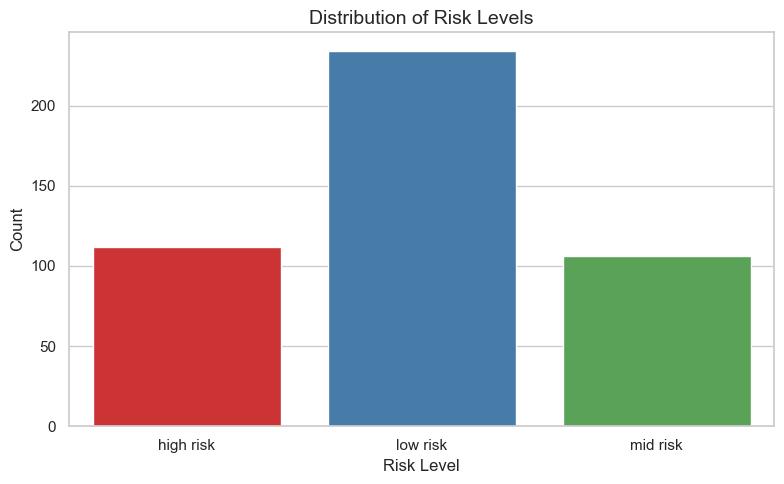

In [127]:

# Plot the histogram with count labels
plt.figure(figsize=(8, 5))
ax = sns.countplot(x="RiskLevel", data=df, hue="RiskLevel", palette="Set1", legend=False)
plt.title("Distribution of Risk Levels", fontsize=14)
plt.xlabel("Risk Level", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

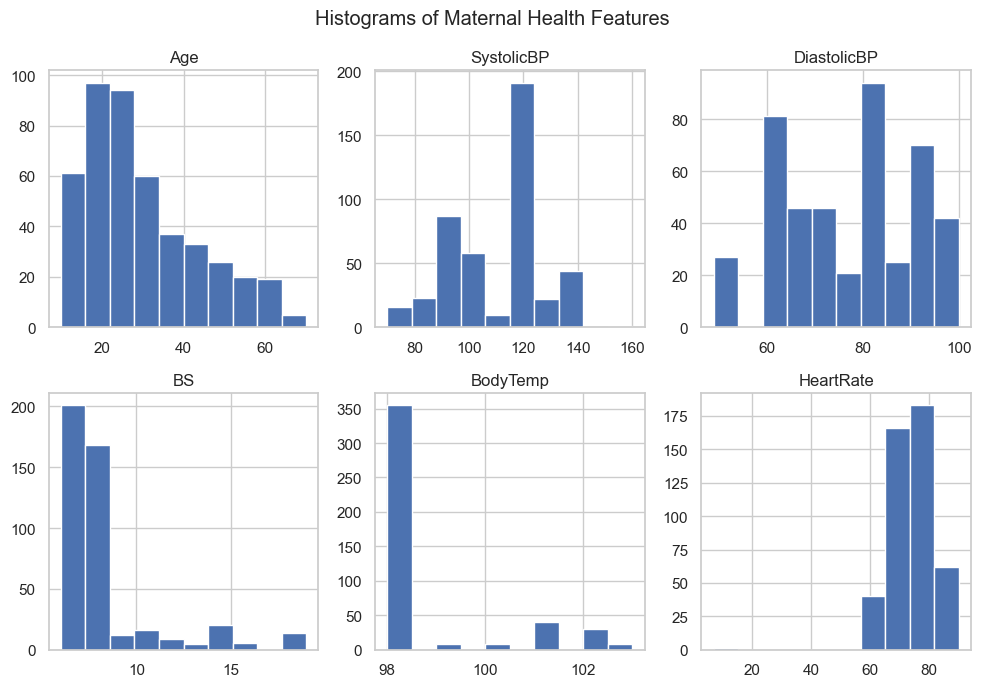

In [128]:
# Plot historgram for each features
df.hist(figsize=(10, 7), layout=(2, 3))
plt.suptitle("Histograms of Maternal Health Features")
plt.tight_layout()

## Model 1 - Logistic Regression

In [129]:
# Copy df for df_LR
df_LR = df
# Convert Body Temp and BS to log values
df_LR['BS'] = np.log(df_LR['BS'])
df_LR['BodyTemp'] = np.log(df_LR['BodyTemp'])

In [130]:
# Create features and label data X, y
X = df_LR.drop("RiskLevel", axis=1)
# Convert the lable data to numeric and categorical for classificaion
label_map = {"low risk":0, "mid risk":1, "high risk":2}
y = df_LR["RiskLevel"].map(label_map)
y = tf.keras.utils.to_categorical(y)
print(X.shape)
print(y.shape)

(452, 6)
(452, 3)


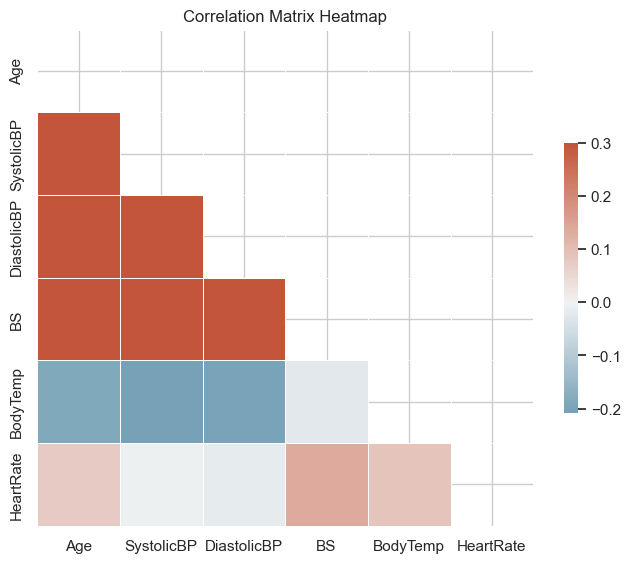

In [131]:
# Plot Correlation Matrix Heatmap

# df["RiskLevel"] = df["RiskLevel"].map(label_map)
corr = X.corr()
# Create for the upper triangle (remove the same corr)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 7))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix Heatmap', fontsize=12)
plt.show()

In [139]:
# Create training data, validation data, and testing data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=1234)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1234)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(316, 6) (68, 6) (68, 6) (316, 3) (68, 3) (68, 3)


In [140]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val) 
X_test = scaler.transform(X_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(316, 6) (68, 6) (316, 3) (68, 3)


In [141]:
# Define model
model = tf.keras.Sequential(
    [
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(
        units = 3,
        use_bias=True,
        activation="softmax",
        kernel_initializer='ones',  
        bias_initializer='ones',     
        )
    ]
)
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
history_lr = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val, y_val), 
    verbose=0)
# print last accuracy, loss for training and validation
print("Last training accuracy:", round(history_lr.history["accuracy"][-1], 4))
print("Last validation accuracy:", round(history_lr.history["val_accuracy"][-1],4))
print("Last training loss:", round(history_lr.history["loss"][-1], 4))
print("Last validation loss:", round(history_lr.history["val_loss"][-1], 4))


Last training accuracy: 0.6804
Last validation accuracy: 0.5882
Last training loss: 0.7992
Last validation loss: 0.8902


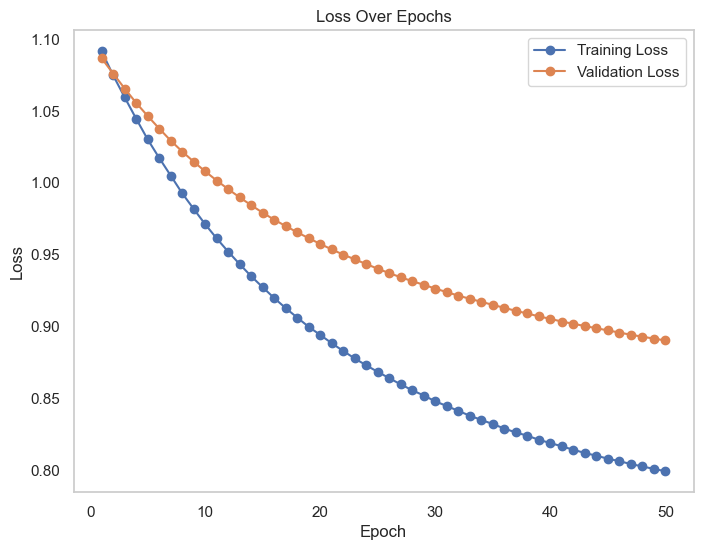

In [142]:
# Plot the losses
plt.figure(figsize=(8, 6))
epochs = range(1, len(history_lr.history['loss']) + 1)
plt.plot(epochs, history_lr.history['loss'], label='Training Loss', marker='o')
plt.plot(epochs, history_lr.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [156]:
# Hyperparameter Tuning, try different epochs and batch_sizes and print out results
def experiment_parameters(epochs_list, batch_sizes_list):
    results = []
    for ep in epochs_list:
        for bs in batch_sizes_list:
            print(f"Training with epochs={ep}, batch_size={bs} ...")

            # Train the model
            history = model.fit(
                X_train, y_train,
                epochs=ep,
                batch_size=bs,
                validation_data=(X_val, y_val),
                verbose=0 
            )
            
            # Extract the last training/validation loss and accuracy
            train_loss = history.history["loss"][-1]
            train_acc = history.history["accuracy"][-1]
            val_loss = history.history["val_loss"][-1]
            val_acc = history.history["val_accuracy"][-1]
            
            # Store the results
            results.append({
                "Epochs": ep,
                "Batch Size": bs,
                "Train Accuracy": round(train_acc, 4),
                "Val Accuracy": round(val_acc, 4),
                "Train Loss": round(train_loss, 4),
                "Val Loss": round(val_loss, 4),
            })
            
    # Convert to a DataFrame for easy viewing
    df_results = pd.DataFrame(results)
    print(df_results)
# Set parameters
epochs_list=[10, 20, 50, 100]
batch_sizes_list=[16, 32, 64, 128]
# Call function
experiment_parameters(epochs_list,  batch_sizes_list)




Training with epochs=10, batch_size=16 ...
Training with epochs=10, batch_size=32 ...
Training with epochs=10, batch_size=64 ...
Training with epochs=10, batch_size=128 ...
Training with epochs=20, batch_size=16 ...
Training with epochs=20, batch_size=32 ...
Training with epochs=20, batch_size=64 ...
Training with epochs=20, batch_size=128 ...
Training with epochs=50, batch_size=16 ...
Training with epochs=50, batch_size=32 ...
Training with epochs=50, batch_size=64 ...
Training with epochs=50, batch_size=128 ...
Training with epochs=100, batch_size=16 ...
Training with epochs=100, batch_size=32 ...
Training with epochs=100, batch_size=64 ...
Training with epochs=100, batch_size=128 ...
    Epochs  Batch Size  Train Accuracy  Val Accuracy  Train Loss  Val Loss
0       10          16          0.6899        0.5882      0.7459    0.8050
1       10          32          0.6867        0.5882      0.7456    0.8048
2       10          64          0.6867        0.5882      0.7454    0.8051
3   

In [161]:
# Pick the best parameters to build model_tuned
model_tuned = tf.keras.Sequential(
    [
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(
        units = 3,
        use_bias=True,
        activation="softmax",
        kernel_initializer='ones',  
        bias_initializer='ones',     
        )
    ]
)
# Compile the model
model_tuned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
model_tuned.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val, y_val), 
    verbose=0)

In [162]:
# Get predictions on the training dataset
y_train_pred1 = model_tuned.predict(X_train)
y_train_pred_labels = np.argmax(y_train_pred1, axis=1)
# Get predictions on the test dataset 
y_test_pred = model_tuned.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Convert one-hot encoded y_train and y_test back to class labels
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Compute accuracy scores
train_accuracy = accuracy_score(y_train_labels, y_train_pred_labels)
test_accuracy = accuracy_score(y_test_labels, y_test_pred_labels)

# Display results
print("Train Accuracy:", round(train_accuracy, 4))
print("Test Accuracy:", round(test_accuracy, 4))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train Accuracy: 0.6772
Test Accuracy: 0.6471


## Model 2 - Random Forest

In [198]:
# Import additional libraries
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

In [184]:
# Create features and label data X, y
X = df.drop("RiskLevel", axis=1)
# Convert the lable data to numeric and categorical for classificaion
label_map = {"low risk":0, "mid risk":1, "high risk":2}
y = df["RiskLevel"].map(label_map)
print(X.shape)
print(y.shape)

(452, 6)
(452,)


In [187]:
# Create training data, validation data, and testing data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=1234)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1234)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(316, 6) (68, 6) (68, 6) (316,) (68,) (68,)


In [188]:
# Initialize the RandomForestClassifier with given parameters
clf = ensemble.RandomForestClassifier(
    n_estimators=500,
    n_jobs=1,
    random_state=1234,
    max_depth=12
)
# Train the classifier
clf.fit(X_train, y_train)
# Predictions on training and validation sets
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
# Evaluate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
# Print results
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Training Accuracy: 0.9241
Validation Accuracy: 0.5882


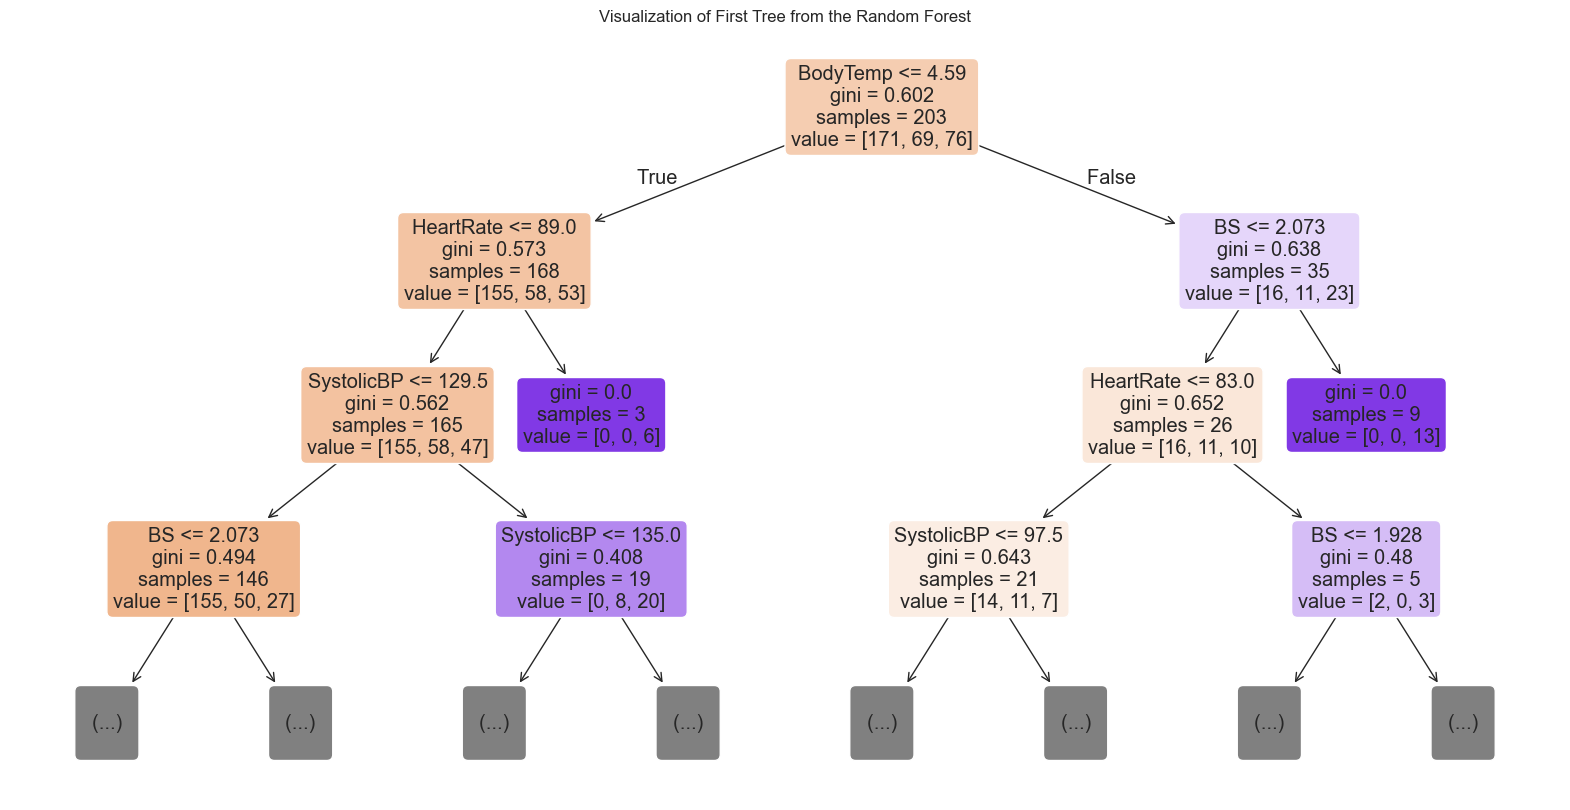

In [211]:
# Plot the first tree from the random forest
plt.figure(figsize=(20, 10))
plot_tree(clf.estimators_[0],
          feature_names=X.columns,
          filled=True,
          rounded=True,
          max_depth=3)  # Limit depth for clarity
plt.title("Visualization of First Tree from the Random Forest")
plt.show()

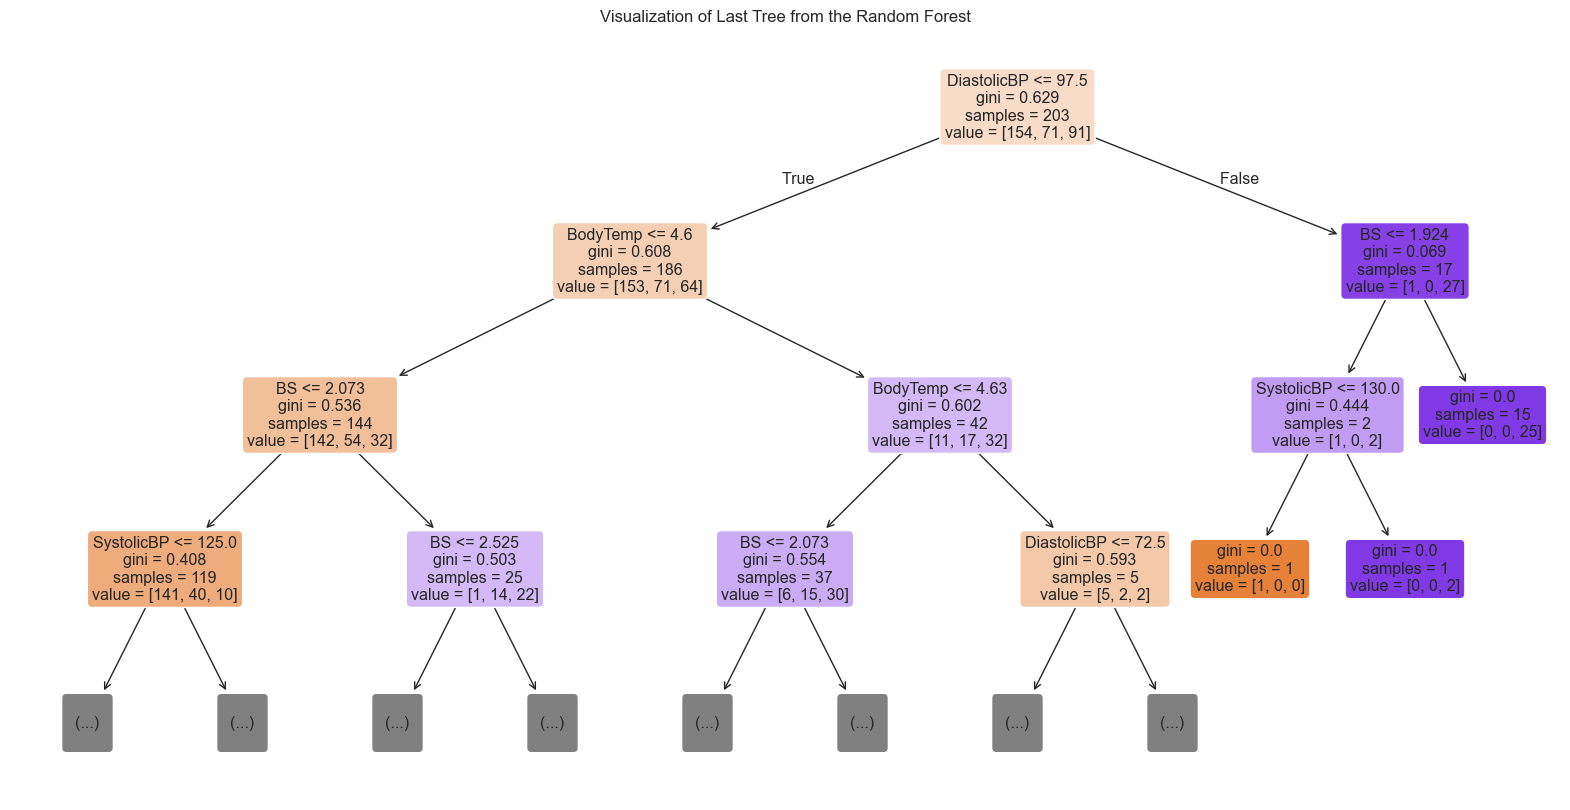

In [210]:
# Plot the last tree from the random forest
plt.figure(figsize=(20, 10))
plot_tree(clf.estimators_[-1],
          feature_names=X.columns,
          filled=True,
          rounded=True,
          max_depth=3)  # Limit depth for clarity
plt.title("Visualization of Last Tree from the Random Forest")
plt.show()

Text(0.5, 1.0, 'Confusion Matrix')

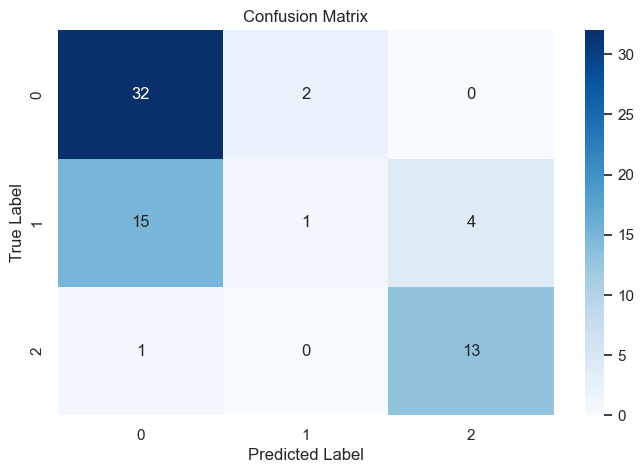

In [212]:
# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

In [213]:
# Hypertune the model
# Define Parameter Grid
param_grid = {
    'max_depth': [3, 5, 7, 10, None],  # None means no limit
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
}

# Initialize a RandomForestClassifier
rf = ensemble.RandomForestClassifier(random_state=1234)

# GridSearchCV with 3-fold cross-validation
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,   # use all CPU cores
    verbose=1
)

# Fit on the training set
grid.fit(X_train, y_train)

# Best parameters and best CV score
print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

# Evaluate on validation set
best_model = grid.best_estimator_
y_val_pred = best_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")

Fitting 3 folds for each of 90 candidates, totalling 270 fits
Best Params: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best CV Score: 0.7373465109314167
Validation Accuracy: 0.6765


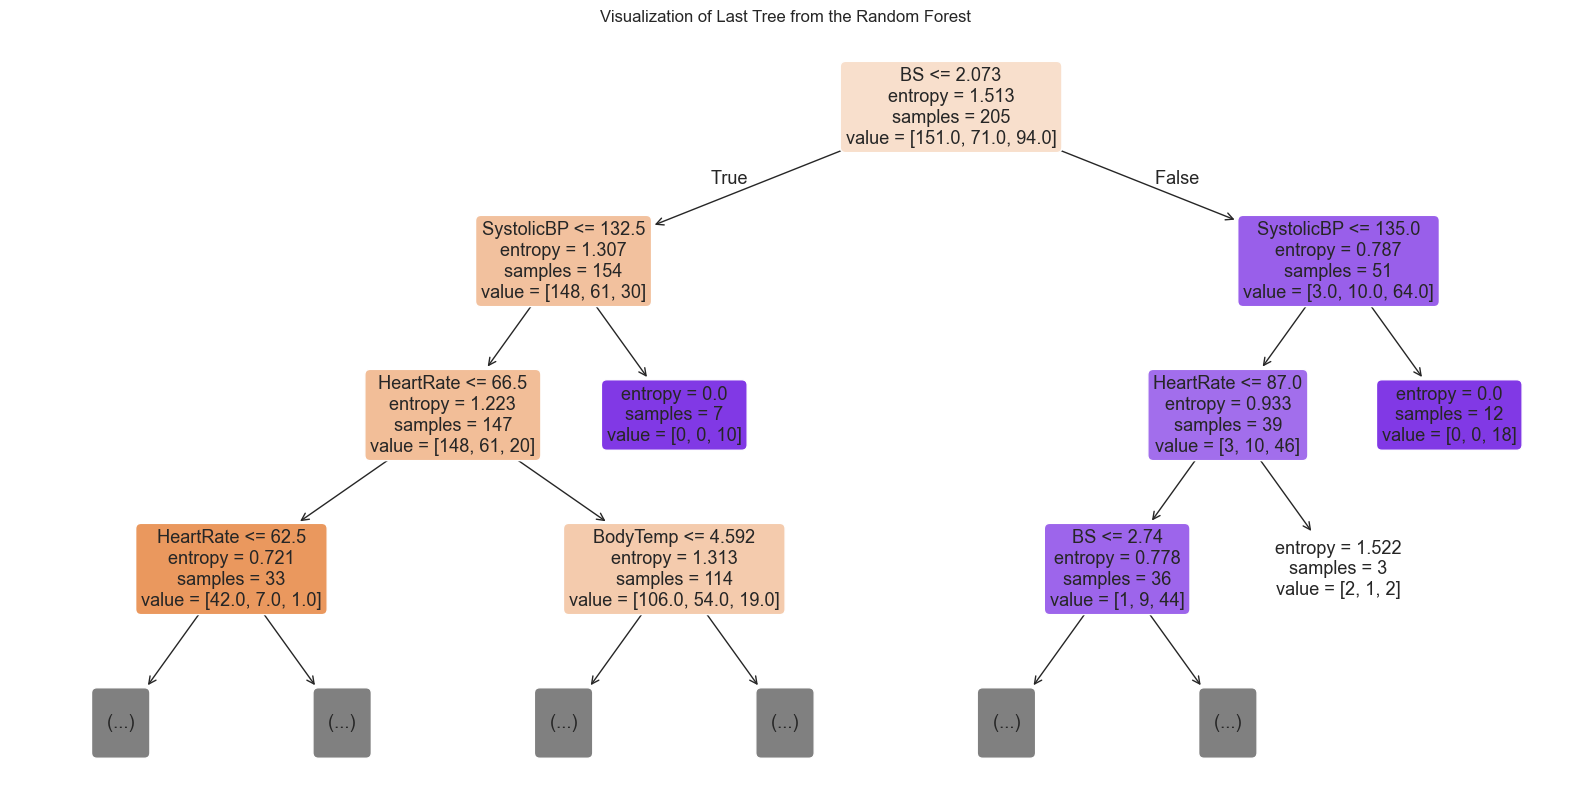

In [216]:
# Plot the last tree from the random forest for best model
plt.figure(figsize=(20, 10))
plot_tree(best_model.estimators_[-1],
          feature_names=X.columns,
          filled=True,
          rounded=True,
          max_depth=3)  # Limit depth for clarity
plt.title("Visualization of Last Tree from the Random Forest")
plt.show()

Text(0.5, 1.0, 'Confusion Matrix')

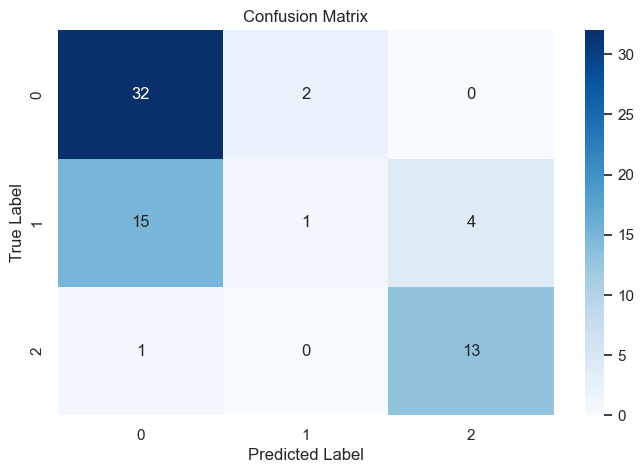

In [217]:
# Compute confusion matrix again
cm = confusion_matrix(y_val, y_val_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

In [218]:
# Check test accuracy
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:     {test_accuracy:.4f}")

Training Accuracy: 0.6772
Test Accuracy:     0.7647


## Model 3 - Artificial Neural Networks

In [227]:
# Create features and label data X, y
X = df.drop("RiskLevel", axis=1)
# Convert the lable data to numeric and categorical for classificaion
label_map = {"low risk":0, "mid risk":1, "high risk":2}
y = df["RiskLevel"].map(label_map)
print(X.shape)
print(y.shape)

(452, 6)
(452,)


In [228]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1234)

# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [230]:
# Initialize the ANN model
model = tf.keras.models.Sequential()

# Add the input layer and first hidden layer
model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
# Add dropout to reduce overfitting
model.add(tf.keras.layers.Dropout(0.3))

# Add a second hidden layer
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

# Add the output layer (3 neurons for 3 classes and softmax activation)
model.add(tf.keras.layers.Dense(3, activation='softmax'))

# Choose an optimizer with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,627 (10.26 KB)

 Trainable params: 2,627 (10.26 KB)

 Non-trainable params: 0 (0.00 B)

In [231]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,  # Use 20% of the training data for validation
    verbose=0
)

# print last accuracy, loss for training and validation
print("Last training accuracy:", round(history.history["accuracy"][-1], 4))
print("Last validation accuracy:", round(history.history["val_accuracy"][-1],4))
print("Last training loss:", round(history.history["loss"][-1], 4))
print("Last validation loss:", round(history.history["val_loss"][-1], 4))

Last training accuracy: 0.7524
Last validation accuracy: 0.7273
Last training loss: 0.5823
Last validation loss: 0.6593


In [233]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Loss: {loss:.4f}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6668 - loss: 0.6934
Test Accuracy: 0.6618
Test Loss: 0.7003


In [234]:
# Hypertune the model
def experiment_parameters(epochs_list, batch_sizes_list):
    results = []
    for ep in epochs_list:
        for bs in batch_sizes_list:
            print(f"Training with epochs={ep}, batch_size={bs} ...")

            # Train the model
            history = model.fit(
                X_train, y_train,
                epochs=ep,
                batch_size=bs,
                validation_split=0.2,
                verbose=0 
            )
            
            # Extract the last training/validation loss and accuracy
            train_loss = history.history["loss"][-1]
            train_acc = history.history["accuracy"][-1]
            val_loss = history.history["val_loss"][-1]
            val_acc = history.history["val_accuracy"][-1]
            
            # Store the results
            results.append({
                "Epochs": ep,
                "Batch Size": bs,
                "Train Accuracy": round(train_acc, 4),
                "Val Accuracy": round(val_acc, 4),
                "Train Loss": round(train_loss, 4),
                "Val Loss": round(val_loss, 4),
            })
            
    # Convert to a DataFrame for easy viewing
    df_results = pd.DataFrame(results)
    print(df_results)
# Set parameters
epochs_list=[5, 10, 20, 50]
batch_sizes_list=[8, 16, 32, 64]
# Call function
experiment_parameters(epochs_list,  batch_sizes_list)

Training with epochs=5, batch_size=8 ...
Training with epochs=5, batch_size=16 ...
Training with epochs=5, batch_size=32 ...
Training with epochs=5, batch_size=64 ...
Training with epochs=10, batch_size=8 ...
Training with epochs=10, batch_size=16 ...
Training with epochs=10, batch_size=32 ...
Training with epochs=10, batch_size=64 ...
Training with epochs=20, batch_size=8 ...
Training with epochs=20, batch_size=16 ...
Training with epochs=20, batch_size=32 ...
Training with epochs=20, batch_size=64 ...
Training with epochs=50, batch_size=8 ...
Training with epochs=50, batch_size=16 ...
Training with epochs=50, batch_size=32 ...
Training with epochs=50, batch_size=64 ...
    Epochs  Batch Size  Train Accuracy  Val Accuracy  Train Loss  Val Loss
0        5           8          0.7427        0.7273      0.6146    0.6460
1        5          16          0.7524        0.7143      0.6214    0.6439
2        5          32          0.7231        0.7143      0.5972    0.6495
3        5          

In [237]:
# Build best model with best result above
model_tuned = tf.keras.models.Sequential()
model_tuned.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model_tuned.add(tf.keras.layers.Dropout(0.3))
model_tuned.add(tf.keras.layers.Dense(32, activation='relu'))
model_tuned.add(tf.keras.layers.Dropout(0.2))
model_tuned.add(tf.keras.layers.Dense(3, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_tuned.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model with best parameter
history_tuned = model_tuned.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,  # Use 20% of the training data for validation
    verbose=0
)
# Print Training and Validation accuracy, loss
print("Last training accuracy:", round(history.history["accuracy"][-1], 4))
print("Last validation accuracy:", round(history.history["val_accuracy"][-1],4))
print("Last training loss:", round(history.history["loss"][-1], 4))
print("Last validation loss:", round(history.history["val_loss"][-1], 4))

# Evaluate on Test Set
loss, accuracy = model_tuned.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Last training accuracy: 0.7524
Last validation accuracy: 0.7273
Last training loss: 0.5823
Last validation loss: 0.6593
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6590 - loss: 0.7313
Test Loss: 0.7414
Test Accuracy: 0.6618
